In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from keras_gpu_callbacks import GPUMetricTrackerCallback

In [2]:
(dataset,), ds_info = tfds.load(
    'bee_dataset/bee_dataset_300',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`.  Stacks label fields into a multi-hot vector."""
    return (
        tf.cast(image, tf.float32) / 255.,
        tf.stack([label['cooling_output'], label['pollen_output'], label['varroa_output'], label['wasps_output']])
    )

dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).cache()
mnist_train = dataset.shuffle(ds_info.splits['train'].num_examples)
dataset = dataset.batch(128)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

Label: [0. 0. 0. 1.]


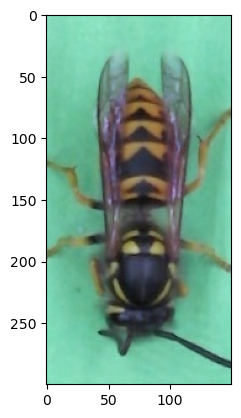

In [3]:
# Visualizes a single instance from the dataset
for input, label in dataset:
    break

example_index = 0

print(f'Label: {label[example_index].numpy()}')
plt.imshow(input[example_index]);

In [20]:
# Defines a simple convolutional network, but powerful enough that training should warm up the GPU a little.
n_outputs = len(ds_info.features['output'])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='gelu', input_shape=(300, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_outputs, activation='sigmoid'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 298, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 74, 32)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 147, 72, 64)       18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 71, 34, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 35, 17, 64)      

In [21]:
# GPUMetricTrackerCallback is needed to update variables so that metrics (which are part of the tensorflow graph) can
# receive updated GPU info.
gpu_tracker_callback = GPUMetricTrackerCallback()

metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    gpu_tracker_callback.utilization_metric(),
    gpu_tracker_callback.clock_speed_metric(),
    gpu_tracker_callback.temperature_metric(),
    gpu_tracker_callback.fan_speed_metric(),
    gpu_tracker_callback.power_usage_metric(),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics
)

In [22]:
history = model.fit(
    dataset,
    epochs=10,
    validation_data=dataset,
    callbacks=[gpu_tracker_callback]
)

Epoch 1/10
 6/59 [==>...........................] - ETA: 6s - loss: 0.5720 - binary_accuracy: 0.7562 - gpu_0_utilization: 72.1667 - gpu_0_clock_speed: 1490.0000 - gpu_0_temperature: 35.1667 - gpu_0_fan_speed: 0.0000e+00 - gpu_0_power_usage: 58126.5000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0471s vs `on_train_batch_end` time: 0.0707s). Check your callbacks.


59/59 [==============================] - 11s 176ms/step - loss: 0.4323 - binary_accuracy: 0.8441 - gpu_0_utilization: 89.8983 - gpu_0_clock_speed: 1892.5424 - gpu_0_temperature: 42.0678 - gpu_0_fan_speed: 15.2542 - gpu_0_power_usage: 267516.5000 - val_loss: 0.4078 - val_binary_accuracy: 0.8534 - val_gpu_0_utilization: 63.5254 - val_gpu_0_clock_speed: 1933.4746 - val_gpu_0_temperature: 43.8983 - val_gpu_0_fan_speed: 30.0000 - val_gpu_0_power_usage: 281294.9375
Epoch 2/10
59/59 [==============================] - 10s 172ms/step - loss: 0.3391 - binary_accuracy: 0.8658 - gpu_0_utilization: 86.4915 - gpu_0_clock_speed: 1932.9661 - gpu_0_temperature: 46.3729 - gpu_0_fan_speed: 30.2712 - gpu_0_power_usage: 309078.3438 - val_loss: 0.2308 - val_binary_accuracy: 0.9051 - val_gpu_0_utilization: 75.2203 - val_gpu_0_clock_speed: 1935.0000 - val_gpu_0_temperature: 46.9831 - val_gpu_0_fan_speed: 30.0000 - val_gpu_0_power_usage: 291591.3750
Epoch 3/10
59/59 [==============================] - 10s 172ms

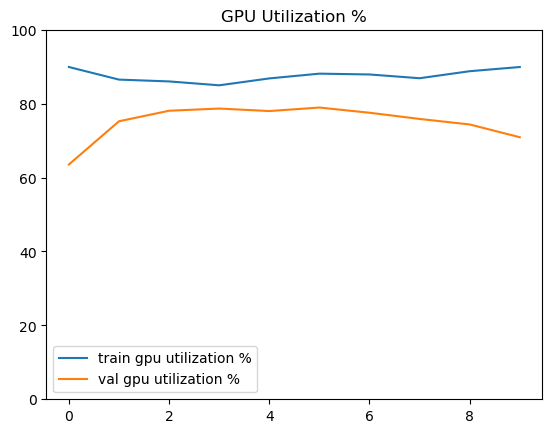

In [23]:
metric_history = history.history

fig, ax = plt.subplots(1, 1)
ax.set_title('GPU Utilization %')
ax.plot(metric_history['gpu_0_utilization'], label='train gpu utilization %')
ax.plot(metric_history['val_gpu_0_utilization'], label='val gpu utilization %')
ax.set_ylim(0, 100)
plt.legend()
plt.show();

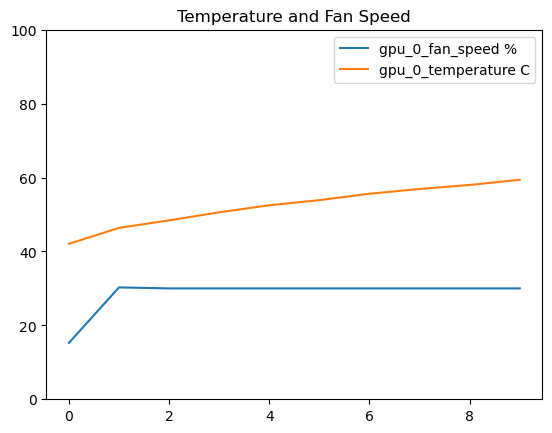

In [24]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Temperature and Fan Speed')
ax.plot(metric_history['gpu_0_fan_speed'], label='gpu_0_fan_speed %')
ax.plot(metric_history['gpu_0_temperature'], label='gpu_0_temperature C')
ax.set_ylim(0, 100)
plt.legend()
plt.show();

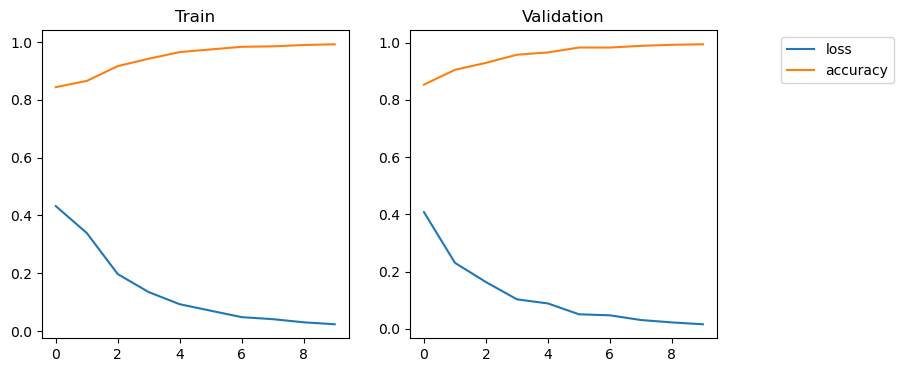

In [25]:
loss_history = history.history

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title('Train')
ax[0].plot(loss_history['loss'], label='loss')
ax[0].plot(loss_history['binary_accuracy'], label='accuracy')

ax[1].set_title('Validation')
ax[1].plot(loss_history['val_loss'], label='loss')
ax[1].plot(loss_history['val_binary_accuracy'], label='accuracy')

plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
plt.subplots_adjust(right=0.8)
plt.show();